<a href="https://colab.research.google.com/github/kashindra-mahato/SOC-support-system/blob/kashindra/IDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##imports

In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
import pickle

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [4]:
path = '/content/drive/MyDrive/Colab Notebooks/DATASET/MachineLearningCVE/'

In [5]:
csv_files=["Monday-WorkingHours.pcap_ISCX",
        "Tuesday-WorkingHours.pcap_ISCX",
        "Wednesday-workingHours.pcap_ISCX",
        "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX",
        "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX",
        "Friday-WorkingHours-Morning.pcap_ISCX",
        "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX",
        "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX",]

##function to append and clean(fill NaN, infinity with 0, remove non imp characters) from dataset

In [6]:
def dfAppendClean(csv_files):
  data = pd.DataFrame()
  for i in range(len(csv_files)):
    df = pd.read_csv(path + csv_files[i] + ".csv")
    data = data.append(df)
    data = data.fillna(0)
    data[' Label'] = data[' Label'].str.replace(r'[^\w\s]+', '')
    data = data.replace([np.inf, -np.inf], 0)
  return data

In [7]:
data = dfAppendClean(csv_files)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


In [8]:
# check if all the columns in dataframe contains numbers
data.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())

 Destination Port                True
 Flow Duration                   True
 Total Fwd Packets               True
 Total Backward Packets          True
Total Length of Fwd Packets      True
 Total Length of Bwd Packets     True
 Fwd Packet Length Max           True
 Fwd Packet Length Min           True
 Fwd Packet Length Mean          True
 Fwd Packet Length Std           True
Bwd Packet Length Max            True
 Bwd Packet Length Min           True
 Bwd Packet Length Mean          True
 Bwd Packet Length Std           True
Flow Bytes/s                     True
 Flow Packets/s                  True
 Flow IAT Mean                   True
 Flow IAT Std                    True
 Flow IAT Max                    True
 Flow IAT Min                    True
Fwd IAT Total                    True
 Fwd IAT Mean                    True
 Fwd IAT Std                     True
 Fwd IAT Max                     True
 Fwd IAT Min                     True
Bwd IAT Total                    True
 Bwd IAT Mea

In [9]:
data[' Label'].unique()

array(['BENIGN', 'FTPPatator', 'SSHPatator', 'DoS slowloris',
       'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed',
       'Web Attack  Brute Force', 'Web Attack  XSS',
       'Web Attack  Sql Injection', 'Infiltration', 'Bot', 'PortScan',
       'DDoS'], dtype=object)

##make three groups a.greater than 1100 b.less than 600 and c. inbetween

In [10]:
a = (data.iloc[:,-1].value_counts())

In [11]:
df_a = pd.DataFrame(a)
df_a.reset_index(inplace=True)
df_a.columns = ['label','count']

In [12]:
df_a

,label,count
0,BENIGN,2273097
1,DoS Hulk,231073
2,PortScan,158930
3,DDoS,128027
4,DoS GoldenEye,10293
5,FTPPatator,7938
6,SSHPatator,5897
7,DoS slowloris,5796
8,DoS Slowhttptest,5499
9,Bot,1966


In [13]:
large_grp = df_a.loc[df_a['count'] > 11000]

In [14]:
medium_grp = df_a.loc[(df_a['count'] < 11000) & (df_a['count'] > 600)]

In [15]:
small_grp = df_a.loc[df_a['count'] < 600]

In [16]:
benign = df_a['count'].loc[df_a['label'] == 'BENIGN'].sum()
total = df_a['count'].sum()
attacks = df_a['count'].loc[df_a['label'] != 'BENIGN'].sum()

In [17]:
labels = ['benign','attacks']
values = [benign, attacks]

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()


In [18]:
def barPlot(df):
  fig = go.Figure(go.Bar(
    x=df['count'],
    y=df['label'],
    marker=dict(
        color='rgba(50, 171, 96, 0.6)',
        line=dict(
            color='rgba(50, 171, 96, 1.0)',
            width=1),
    ),
    name='duh',
    orientation='h',
    ))
  fig.show()

In [19]:
barPlot(small_grp)

In [20]:
barPlot(medium_grp)

In [21]:
barPlot(large_grp)

In [22]:
data.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

##remove preceding whitespaces from column names

In [23]:
data.columns = ['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count',
       'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count',
       'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size',
       'Avg Fwd Segment Size', 'Avg Bwd Segment Size',
       'Fwd Header Length.1', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk',
       'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk',
       'Bwd Avg Bulk Rate', 'Subflow Fwd Packets', 'Subflow Fwd Bytes',
       'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward',
       'Init_Win_bytes_backward', 'act_data_pkt_fwd',
       'min_seg_size_forward', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min',
       'Label']

In [24]:
data.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [25]:
data['Label'].unique()

array(['BENIGN', 'FTPPatator', 'SSHPatator', 'DoS slowloris',
       'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed',
       'Web Attack  Brute Force', 'Web Attack  XSS',
       'Web Attack  Sql Injection', 'Infiltration', 'Bot', 'PortScan',
       'DDoS'], dtype=object)

##form seperate dataframes for each class(label)

In [26]:
df_BENIGN = data.loc[data['Label'] == 'BENIGN']

In [27]:
df_FTPPatator = data.loc[data['Label'] == 'FTPPatator']

In [28]:
df_SSHPatator = data.loc[data['Label'] == 'SSHPatator']

In [29]:
df_DoS_slowloris = data.loc[data['Label'] == 'DoS slowloris']

In [30]:
df_DoS_Slowhttptest = data.loc[data['Label'] == 'DoS Slowhttptest']

In [31]:
df_DoS_Hulk = data.loc[data['Label'] == 'DoS Hulk']

In [32]:
df_DoS_GoldenEye = data.loc[data['Label'] == 'DoS GoldenEye']

In [33]:
df_Heartbleed = data.loc[data['Label'] == 'Heartbleed']

In [34]:
df_Web_Attack_Brute_Force = data.loc[data['Label'] == 'Web Attack  Brute Force']

In [35]:
df_Web_Attack_XSS = data.loc[data['Label'] == 'Web Attack  XSS']

In [36]:
df_Web_Attack_Sql_Injection = data.loc[data['Label'] == 'Web Attack  Sql Injection']

In [37]:
df_Infiltration = data.loc[data['Label'] == 'Infiltration']

In [38]:
df_Bot = data.loc[data['Label'] == 'Bot']

In [39]:
df_PortScan = data.loc[data['Label'] == 'PortScan']

In [40]:
df_DDoS = data.loc[data['Label'] == 'DDoS']

##function to combine dataframes(ifraction is the fraction that we want df1 to be of total dataframe size)

In [41]:
def combineDf(df1, df2, ifraction):
  n = int(((1-ifraction)/ifraction)*len(df1))
  df3 = df2.sample(n=n)
  df4 = df3.append(df1)
  return df4.sample(frac=1)

##combine all the dataframes with benign dataframe with former being 30% of total size

In [42]:
df_FTPPatator_benign = combineDf(df_FTPPatator, df_BENIGN, 0.3)

In [43]:
df_SSHPatator_benign = combineDf(df_SSHPatator, df_BENIGN, 0.3)

In [44]:
df_DoS_Slowhttptest_benign = combineDf(df_DoS_Slowhttptest, df_BENIGN, 0.3)

In [45]:
df_DoS_Hulk_benign = combineDf(df_DoS_Hulk, df_BENIGN, 0.3)

In [46]:
df_DoS_GoldenEye_benign = combineDf(df_DoS_GoldenEye, df_BENIGN, 0.3)

In [47]:
df_Heartbleed_benign = combineDf(df_Heartbleed, df_BENIGN, 0.3)

In [48]:
df_Web_Attack_Brute_Force_benign = combineDf(df_Web_Attack_Brute_Force, df_BENIGN, 0.3)

In [49]:
df_Web_Attack_XSS_benign = combineDf(df_Web_Attack_XSS, df_BENIGN, 0.3)

In [50]:
df_Web_Attack_Sql_Injection_benign = combineDf(df_Web_Attack_Sql_Injection, df_BENIGN, 0.3)

In [51]:
df_Infiltration_benign = combineDf(df_Infiltration, df_BENIGN, 0.3)

In [52]:
df_Bot_benign = combineDf(df_Bot, df_BENIGN, 0.3)

In [53]:
df_PortScan_benign = combineDf(df_PortScan, df_BENIGN, 0.3)

In [54]:
df_DDoS_benign = combineDf(df_DDoS, df_BENIGN, 0.3)

##combine web attacks and finally combine it with benign

In [55]:
df_temp = df_Web_Attack_Brute_Force.append(df_Web_Attack_XSS)

In [56]:
df_Web_Attack = df_temp.append(df_Web_Attack_Sql_Injection)

In [57]:
df_Web_Attack_benign = combineDf(df_Web_Attack, df_BENIGN, 0.3)

##check the feature importance for each of above cases

####function to plot feature importance

In [58]:
def plot_feature_importance(imp, names, threshold):
  # convert both imp and names to np array in order
  # to have 2 column dataframe
  feature_imp = np.array(imp)
  feature_names = np.array(names)
  #create dataframe using a dictionary
  data = {'feature_names':feature_names, 'feature_importance':feature_imp}
  fi_df = pd.DataFrame(data)

  #sort the df in descending order
  fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
  df_i = fi_df.loc[fi_df['feature_importance'] > threshold]
  #barplot
  plt.figure(figsize=(10,10))
  sns.barplot(x=df_i['feature_importance'], y=df_i['feature_names'])
  plt.title('FEATURE IMPORTANCE')
  plt.xlabel('feature importance')
  plt.ylabel('feature names')
  return df_i

####function to train model and plot the feature importance

In [59]:
def trainPlot(df, threshold, path, df_name):
  rfc_model = RandomForestClassifier(n_estimators=100, max_depth=5)
  X = df.drop(columns=['Label'])
  y = df['Label']
  rfc_model.fit(X,y)
  pickle.dump(rfc_model, open(path + str(df_name) +'.sav', 'wb'))
  df = plot_feature_importance(rfc_model.feature_importances_,X.columns,threshold)
  return df

In [60]:
path = '/content/drive/MyDrive/Colab Notebooks/models/'

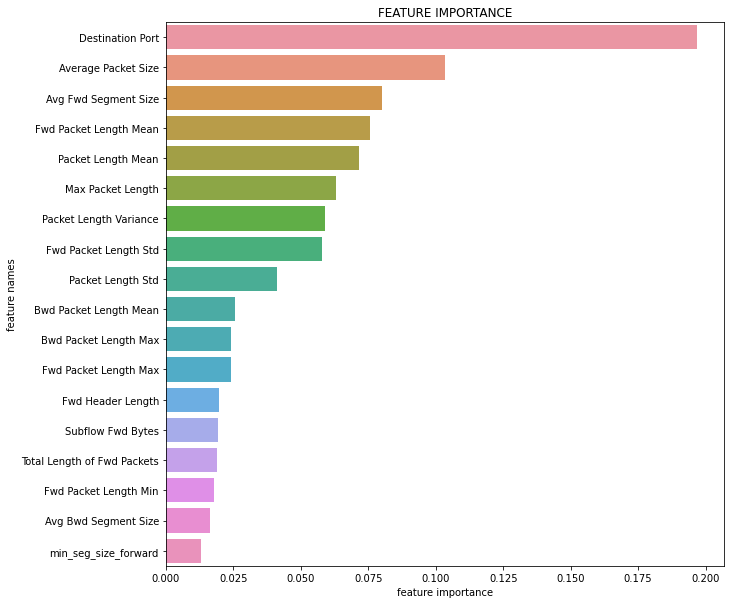

In [61]:
df_FTPPatator_benign_plot = trainPlot(df_FTPPatator_benign, 0.01, path, 'df_FTPPatator_benign')

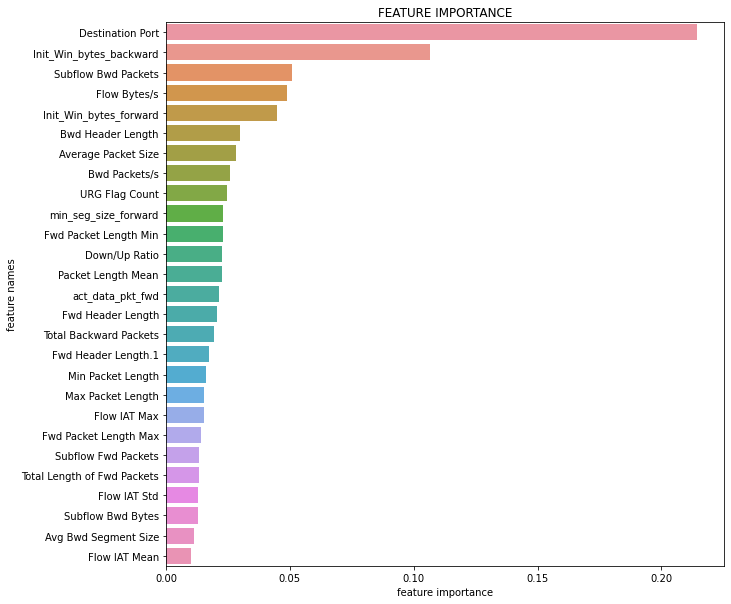

In [62]:
df_SSHPatator_benign_plot = trainPlot(df_SSHPatator_benign, 0.01, path, 'df_SSHPatator_benign')

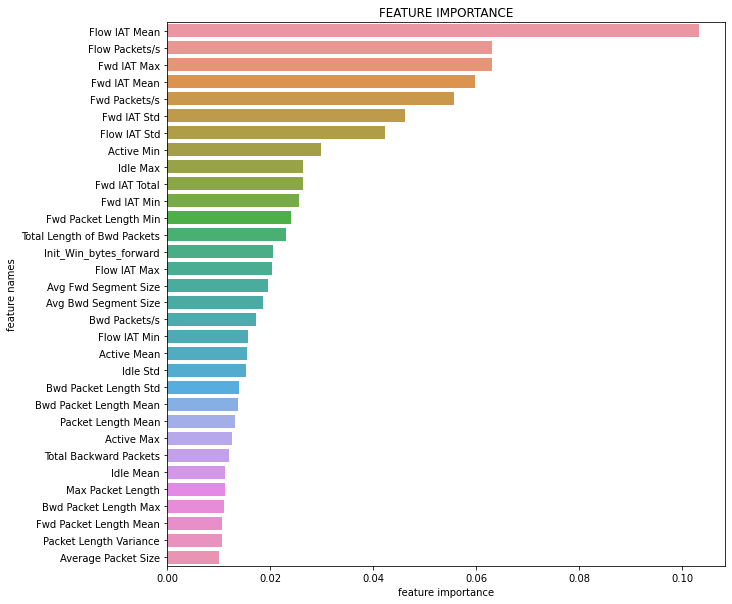

In [63]:
df_DoS_Slowhttptest_benign_plot = trainPlot(df_DoS_Slowhttptest_benign, 0.01, path, 'df_DoS_Slowhttptest_benign')

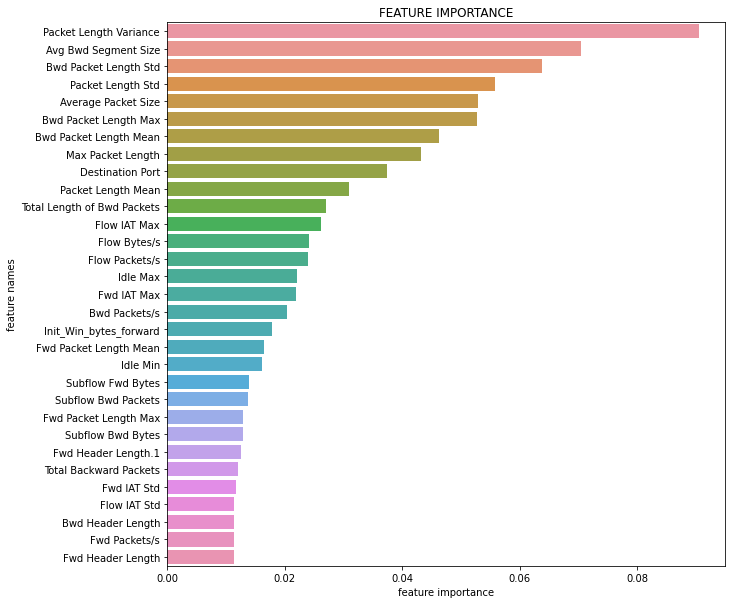

In [64]:
df_DoS_Hulk_benign_plot = trainPlot(df_DoS_Hulk_benign, 0.01, path, 'df_DoS_Hulk_benign')

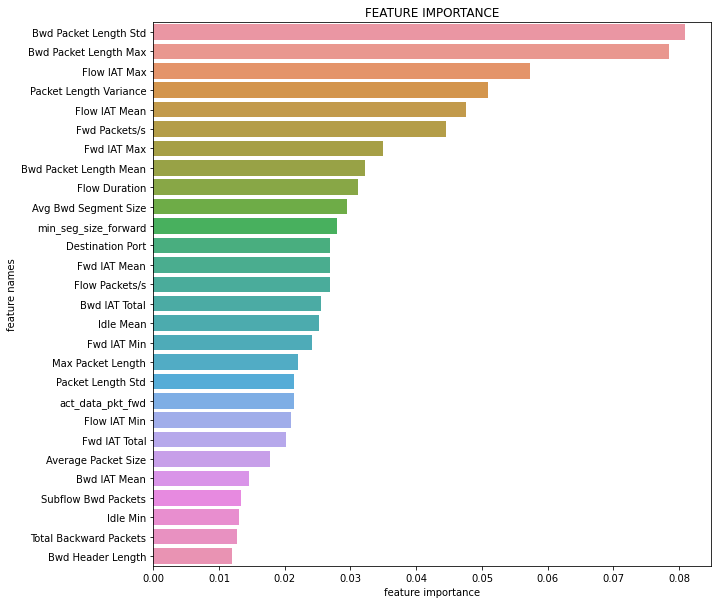

In [65]:
df_DoS_GoldenEye_benign_plot = trainPlot(df_DoS_GoldenEye_benign, 0.01, path, 'df_DoS_GoldenEye_benign')

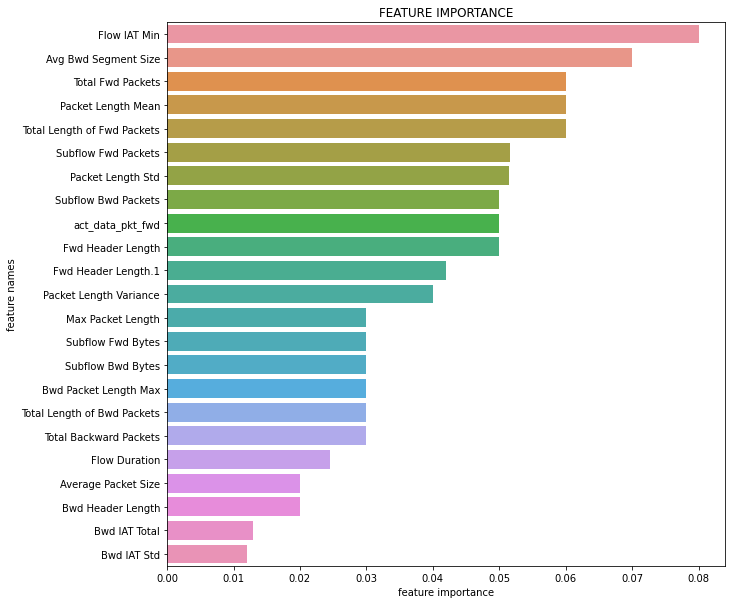

In [66]:
df_Heartbleed_benign_plot = trainPlot(df_Heartbleed_benign, 0.01, path, 'df_Heartbleed_benign')

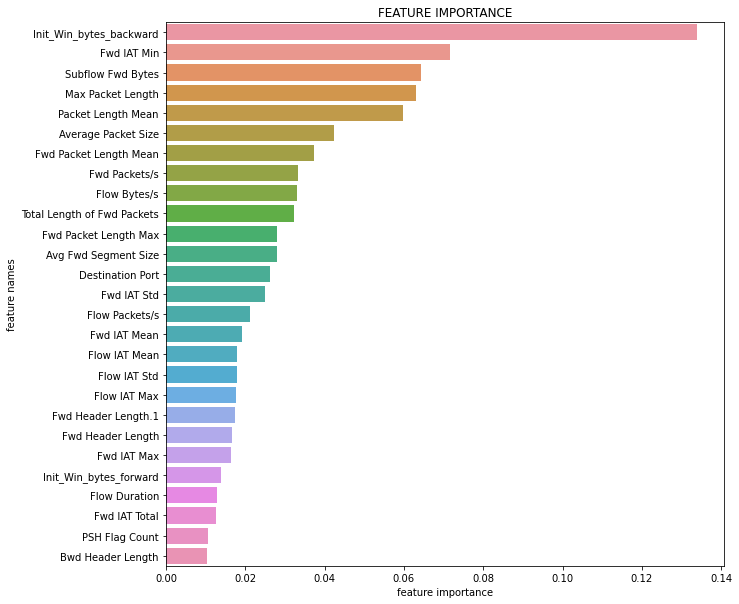

In [67]:
df_Web_Attack_Brute_Force_benign_plot = trainPlot(df_Web_Attack_Brute_Force_benign, 0.01, path, 'df_Web_Attack_Brute_Force_benign')

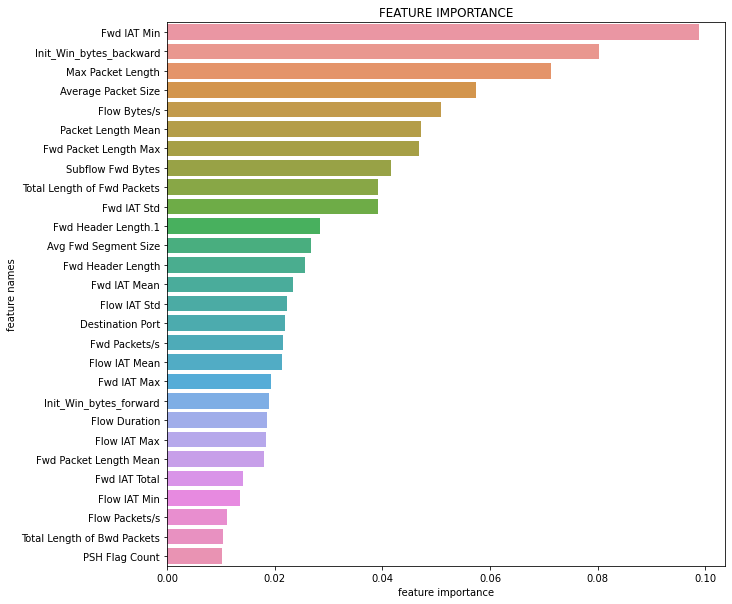

In [68]:
df_Web_Attack_XSS_benign_plot = trainPlot(df_Web_Attack_XSS_benign, 0.01, path, 'df_Web_Attack_XSS_benign')

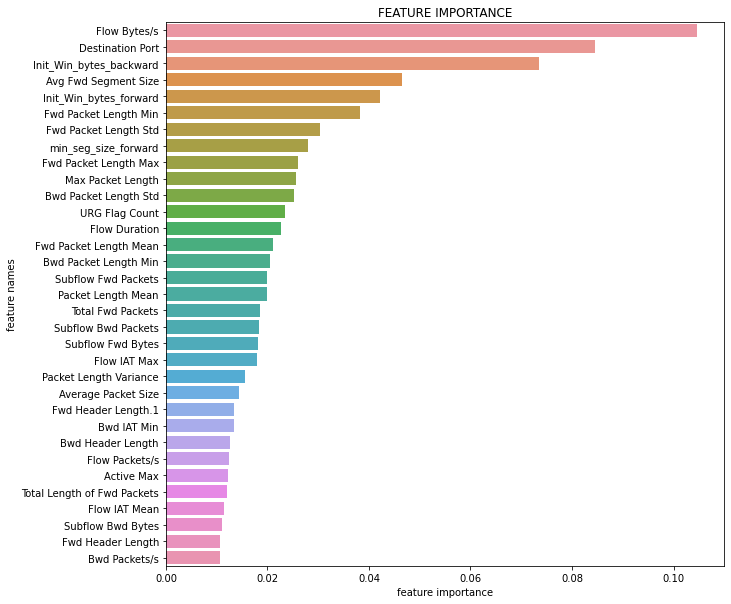

In [69]:
df_Web_Attack_Sql_Injection_benign_plot = trainPlot(df_Web_Attack_Sql_Injection_benign, 0.01, path, 'df_Web_Attack_Sql_Injection_benign')

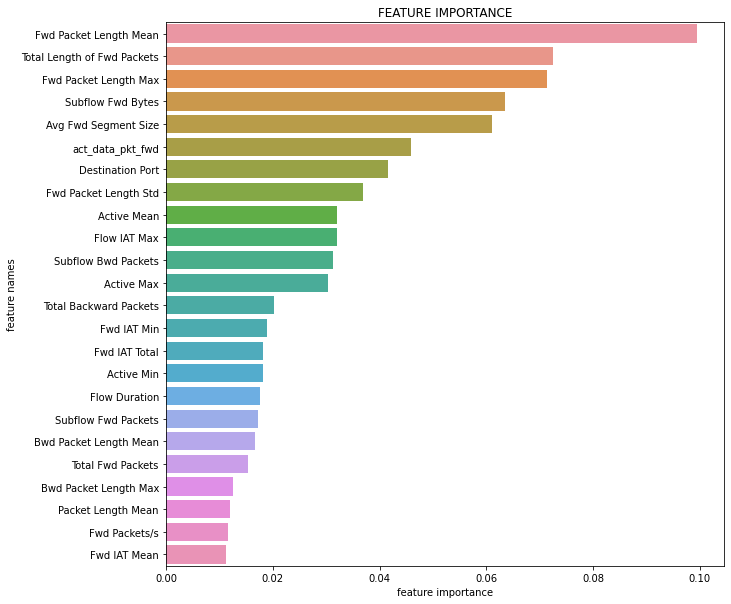

In [70]:
df_Infiltration_benign_plot = trainPlot(df_Infiltration_benign, 0.01, path, 'df_Infiltration_benign')

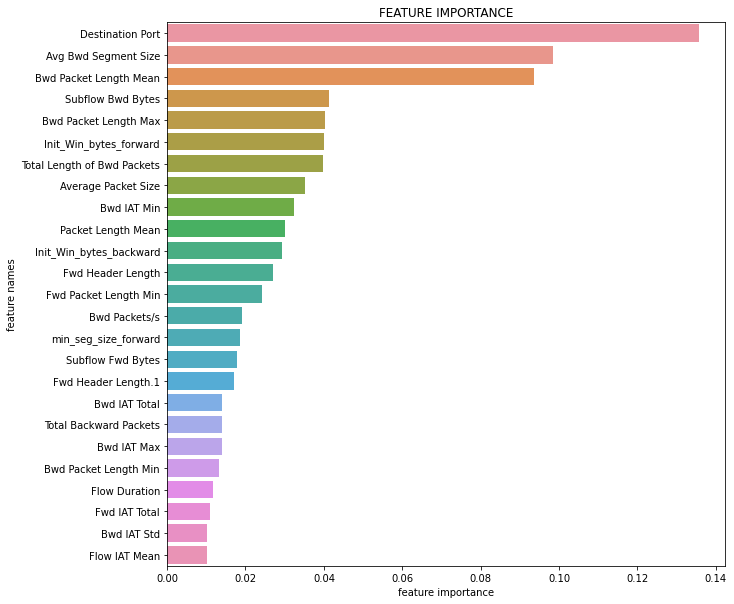

In [71]:
df_Bot_benign_plot = trainPlot(df_Bot_benign, 0.01, path, 'df_Bot_benign')

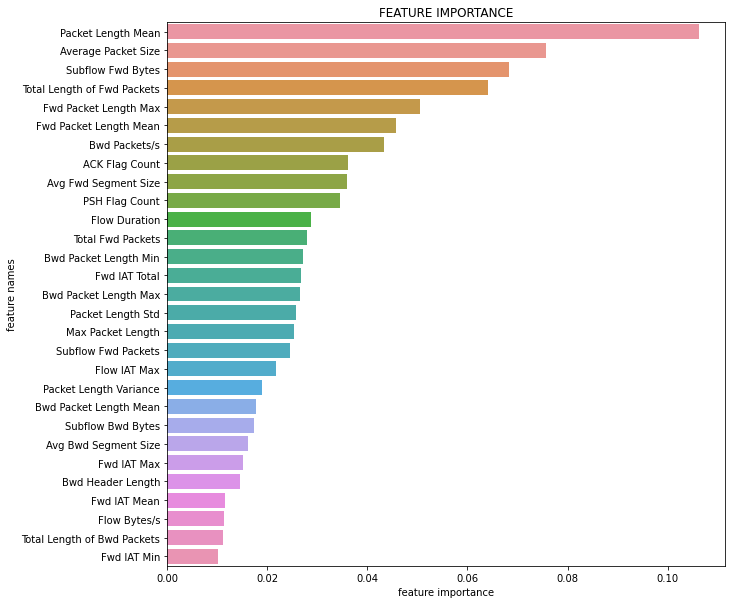

In [72]:
df_PortScan_benign_plot = trainPlot(df_PortScan_benign, 0.01, path, 'df_PortScan_benign')

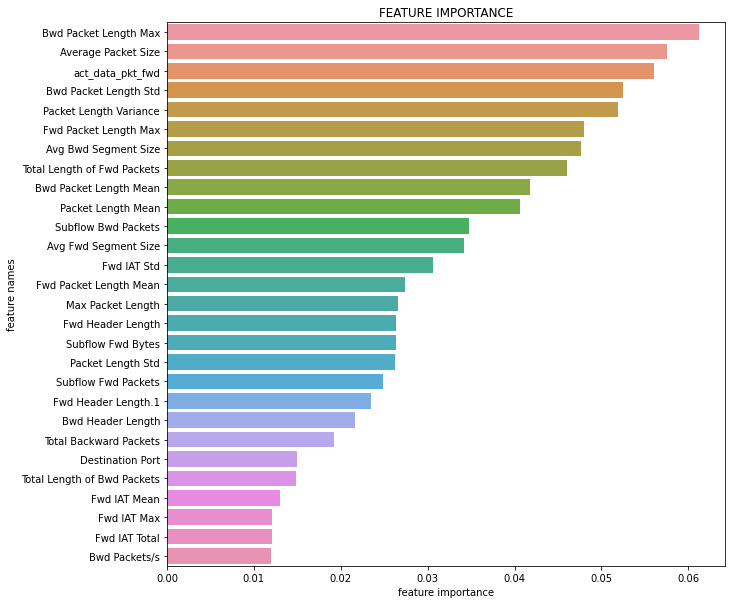

In [73]:
df_DDoS_benign_plot = trainPlot(df_DDoS_benign, 0.01, path, 'df_DDoS_benign')

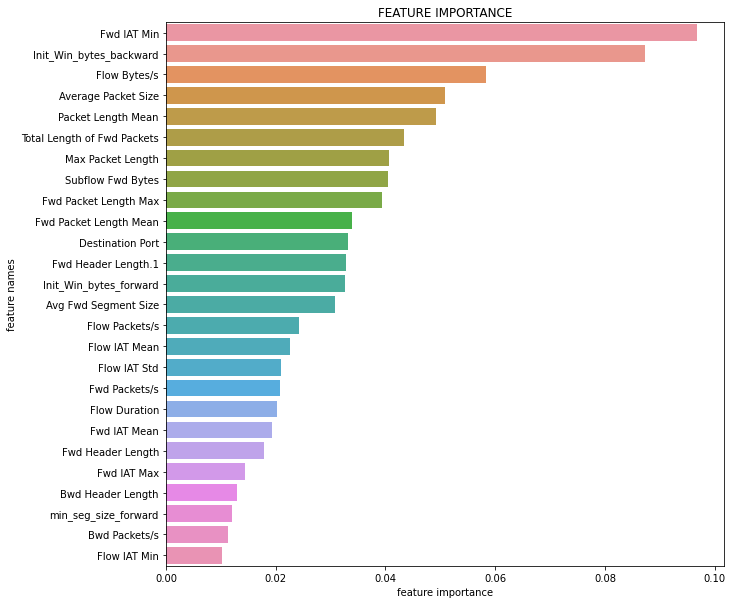

In [74]:
df_Web_Attack_benign_plot = trainPlot(df_Web_Attack_benign, 0.01, path, 'df_Web_Attack_benign')

##Train

In [75]:
def trainIDS(df, df_plot, mod, path, df_name):
  X = df[df_plot.iloc[0:10]['feature_names']]
  y = df['Label']

  # train and test split
  X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
  
  # models
  if mod == 'logic':
    model = LogisticRegression()
    model.fit(X_train, y_train)
    pickle.dump(model, open(path + 'IDS'+str(df_name)+'_logic_model.sav', 'wb'))
    print(model.score(X_test, y_test))
  
  if mod == 'sgd':
    model = SGDClassifier(loss='perceptron')
    model.fit(X_train, y_train)
    pickle.dump(model, open(path + 'IDS_sgd_model.sav', 'wb'))
    print(model.score(X_test, y_test))
    return model

In [76]:
trainIDS(df_FTPPatator_benign, df_FTPPatator_benign_plot, 'logic', path, 'df_FTPPatator_benign')
trainIDS(df_FTPPatator_benign, df_FTPPatator_benign_plot, 'sgd', path, 'df_FTPPatator_benign')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.9990551776266062
0.99848828420257


SGDClassifier(loss='perceptron')

In [77]:
trainIDS(df_SSHPatator_benign, df_SSHPatator_benign_plot, 'logic', path, 'df_SSHPatator_benign')
trainIDS(df_SSHPatator_benign, df_SSHPatator_benign_plot, 'sgd', path, 'df_SSHPatator_benign')

0.9916073245167853
0.9498982706002035


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



SGDClassifier(loss='perceptron')

In [78]:
trainIDS(df_DoS_Slowhttptest_benign, df_DoS_Slowhttptest_benign_plot, 'logic', path, 'df_DoS_Slowhttptest_benign')
trainIDS(df_DoS_Slowhttptest_benign, df_DoS_Slowhttptest_benign_plot, 'sgd', path, 'df_DoS_Slowhttptest_benign')

0.682760501909438
0.4148936170212766


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



SGDClassifier(loss='perceptron')

In [79]:
trainIDS(df_DoS_Hulk_benign, df_DoS_Hulk_benign_plot, 'logic', path, 'df_DoS_Hulk_benign')
trainIDS(df_DoS_Hulk_benign, df_DoS_Hulk_benign_plot, 'sgd', path, 'df_DoS_Hulk_benign')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.8986815883257925
0.8901063947185636


SGDClassifier(loss='perceptron')

In [80]:
trainIDS(df_DoS_GoldenEye_benign, df_DoS_GoldenEye_benign_plot, 'logic', path, 'df_DoS_GoldenEye_benign')
trainIDS(df_DoS_GoldenEye_benign, df_DoS_GoldenEye_benign_plot, 'sgd', path, 'df_DoS_GoldenEye_benign')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.9440396385893326
0.7493442145147188


SGDClassifier(loss='perceptron')

In [81]:
trainIDS(df_Heartbleed_benign, df_Heartbleed_benign_plot, 'logic', path, 'df_Heartbleed_benign')
trainIDS(df_Heartbleed_benign, df_Heartbleed_benign_plot, 'sgd', path, 'df_Heartbleed_benign')

1.0
1.0


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



SGDClassifier(loss='perceptron')

In [82]:
trainIDS(df_Web_Attack_Brute_Force_benign, df_Web_Attack_Brute_Force_benign_plot, 'logic', path, 'df_Web_Attack_Brute_Force_benign')
trainIDS(df_Web_Attack_Brute_Force_benign, df_Web_Attack_Brute_Force_benign_plot, 'sgd', path, 'df_Web_Attack_Brute_Force_benign')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.9223880597014925
0.9313432835820895


SGDClassifier(loss='perceptron')

In [83]:
trainIDS(df_Web_Attack_XSS_benign, df_Web_Attack_XSS_benign_plot, 'logic', path, 'df_Web_Attack_XSS_benign')
trainIDS(df_Web_Attack_XSS_benign, df_Web_Attack_XSS_benign_plot, 'sgd', path, 'df_Web_Attack_XSS_benign')

0.9287356321839081
0.9195402298850575


SGDClassifier(loss='perceptron')

In [84]:
trainIDS(df_Web_Attack_Sql_Injection_benign, df_Web_Attack_Sql_Injection_benign_plot, 'logic', path, 'df_Web_Attack_Sql_Injection_benign')
trainIDS(df_Web_Attack_Sql_Injection_benign, df_Web_Attack_Sql_Injection_benign_plot, 'sgd', path, 'df_Web_Attack_Sql_Injection_benign')

1.0
0.6428571428571429


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



SGDClassifier(loss='perceptron')

In [85]:
trainIDS(df_Infiltration_benign, df_Infiltration_benign_plot, 'logic', path, 'df_Infiltration_benign')
trainIDS(df_Infiltration_benign, df_Infiltration_benign_plot, 'sgd', path, 'df_Infiltration_benign')

0.8333333333333334
0.2916666666666667


SGDClassifier(loss='perceptron')

In [86]:
trainIDS(df_Bot_benign, df_Bot_benign_plot, 'logic', path, 'df_Bot_benign')
trainIDS(df_Bot_benign, df_Bot_benign_plot, 'sgd', path, 'df_Bot_benign')

0.6186117467581999
0.5583524027459954


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



SGDClassifier(loss='perceptron')

In [87]:
trainIDS(df_PortScan_benign, df_PortScan_benign_plot, 'logic', path, 'df_PortScan_benign')
trainIDS(df_PortScan_benign, df_PortScan_benign_plot, 'sgd', path, 'df_PortScan_benign')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.9857202182079016
0.9176906959623988


SGDClassifier(loss='perceptron')

In [88]:
trainIDS(df_DDoS_benign, df_DDoS_benign_plot, 'logic', path, 'df_DDoS_benign')
trainIDS(df_DDoS_benign, df_DDoS_benign_plot, 'sgd', path, 'df_DDoS_benign')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.8901841784609617
0.8900670165901209


SGDClassifier(loss='perceptron')

In [89]:
trainIDS(df_Web_Attack_benign, df_Web_Attack_benign_plot, 'logic', path, 'df_Web_Attack_benign')
trainIDS(df_Web_Attack_benign, df_Web_Attack_benign_plot, 'sgd', path, 'df_Web_Attack_benign')

0.8383768913342503
0.7854195323246217


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



SGDClassifier(loss='perceptron')